<a target="_blank" href="https://drive.google.com/file/d/1wwnK9G_2gtwJ81eAUVb4p2lfgE-hGXsG/view?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 7.6 데이터 품질 평가해보기
---

- 최종수정일 : 2024-03-12
- **7.1.에서 생성한 .env 파일도 로드해야 한다**

**폰트 설정 - Colab 환경**
- 다운로드 후 상단의 `런타임 > 세션 다시 시작`을 클릭한 후 다시 실행한다.

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install python-dotenv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import re

from dotenv import load_dotenv
import os
from tqdm import tqdm
load_dotenv(".env")

API_ID = os.getenv("CLIENT_ID")
API_SECRET = os.getenv("CLIENT_SECRET")

import requests
import json
import difflib

# Colab 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 0. 데이터 및 평가 테이블 준비

In [3]:
# 데이터 로드
# 7.4. 에서 정제한 병합한 데이터를 가져온다
# 7.4.를 실행하지 않았다면, 깃허브에 업로드된 데이터를 사용한다
df = pd.read_excel("7-6_merged_clean.xlsx")
df = df.replace(np.nan, None)

### 컬럼 평가 테이블 준비

단순 공백을 계산하면 되는 완전성을 제외하고, 데이터 값마다 정규표현식을 통한 구문 확인이 필요한 품질 요소들에 대해서는 품질 평가 테이블을 생성해 활용한다.

해당 테이블은 평가 대상 컬럼들로 구성되며, 처음에는 데이터셋의 행 수만큼 0으로 채워져 있다.

 데이터에 오류가 존재할 경우 0, 존재하지 않을 경우 1, 값이 존재하지 않을 경우 None 값이 입력된다.

In [4]:
# 이해가능성 평가 테이블
readable = pd.DataFrame(np.zeros((len(df), len(df.columns))), # 0값으로만 채운 데이터셋을 만든다
                     columns= df.columns.tolist())


# 유효성 평가 테이블
valid = pd.DataFrame(np.zeros((len(df), 9)), # 0값으로만 채운 데이터셋을 만든다
                     columns=[ '평일운영시작시각','평일운영종료시각','주말운영시작시각',
                              '주말운영종료시각','유료사용여부','사용안내전화번호'
                              ,'위도','경도','데이터기준일자'])
# 정확성 평가 테이블
factual = pd.DataFrame(np.zeros((len(df), 4)),
                       columns = ['소재지도로명주소','소재지지번주소','위도','경도'])

# 일관성 평가 테이블
consist = pd.DataFrame(np.zeros((len(df), 6)),
                      columns = ['휴관일-주말운영시작시각','휴관일-주말운영종료시각', '유료사용여부-사용료',
                                '소재지도로명주소-소재지지번주소','소재지지번주소-좌표계','소재지도로명주소-좌표계'])

### 컬럼별 지표 시각화 함수

`vis_portion`함수는 평가된 테이블(table)과 그래프에 나타날 평가항목 명칭(name)을 입력받아, 컬럼별 오류/정상/공백 데이터의 비중과 공백을 제외한 데이터 내에서의 정상 데이터의 비율을 보여준다.

In [5]:
def vis_portion(table, name):
    # 데이터의 비율을 기록하는 테이블을 생성
    val_counts = pd.DataFrame()
    for col in table.columns:
        # 평가 대상 컬럼별로 오류/정상/공백 수치를 집계
        valcol = table[col].value_counts()
        # 생성된 집계 테이블을 하나의 테이블로 합침
        val_counts = pd.concat([val_counts, valcol], axis=1)

    # 0, 1, 항목 중 빈 값에 대해서는 계산 오류가 나지 않도록 0을 채움
    val_counts = val_counts.fillna(0)

    # 추후의 시각화를 위해 데이터 프레임의 축을 반전
    val_counts = np.transpose(val_counts)

    # 모든 평가 대상 컬럼들이 단 하나의 값으로만 이뤄져 있을 경우(모두 정상/오류)
    # 시각화를 위해 0으로 된 컬럼을 추가
    if 0 not in val_counts.columns:
        val_counts[0] = 0
    if 1 not in val_counts.columns:
        val_counts[1] = 0

    # 공백값은 집계되지 않으므로, 공백값을 따로 계산
    val_counts["none"] = (len(table)-val_counts[1]-val_counts[0])

    # 정상 데이터의 비율을 계산한 컬럼을 생성
    val_counts[name] = val_counts[1] / (val_counts[1]+val_counts[0]) * 100

    # 정상 데이터의 비율을 기준으로 정렬
    val_counts = val_counts.sort_values(by=0, ascending=True)

    # 시각화
    # 서브플롯 생성
    fig, axes = plt.subplots(1, 2,sharey=True)
    fig.set_size_inches(10, 5)

    # 컬럼별 정상/오류/공백 데이터 비중을 시각화
    axes[0].barh(val_counts.index.tolist(), val_counts[1], color='#afe0ed')
    axes[0].barh(val_counts.index.tolist(), val_counts[0], left=val_counts[1], color='#edafd2')
    axes[0].barh(val_counts.index.tolist(), val_counts["none"], left=val_counts[1]+val_counts[0], color='#ebeded')
    axes[0].set_title("컬럼별 %s 데이터 비중"%name)

    # 컬럼별 정상 데이터의 비율을 시각화
    axes[1].barh(val_counts.index.tolist(), val_counts[name], color='#a78bfa')
    axes[1].set_title("컬럼별 %s성( %s 데이터 / 비공백 데이터 )"%(name,name))

    # 서브플롯 간의 간격 조정하고 비율 수치가 그래프상에 시각화
    plt.subplots_adjust(wspace=0.07)
    for i in range(len(val_counts)):
        axes[1].text(val_counts[name][i]-6, i, f"{round(val_counts[name][i],2)}%", ha="center", va="center")

    # x,y축은 모두 제거
    axes[0].set_frame_on(False)
    axes[1].set_frame_on(False)

    return val_counts

## 1. 완전성

컬럼별 데이터의 완전성을 계산하는 수식은 다음과 같다.

$
complete_i = \frac{length(row)-null(col_i)}{length(data)}
$



해당 식을 반영하여 컬럼별로 데이터의 완전성을 계산한 데이터 프레임 `df_fill_rate`을 생성한다.

In [6]:
# 컬럼별 완전성 데이터프레임

# 컬럼별로 공백 데이터의 비율을 계산
df_fill_rate = pd.DataFrame(df.isnull().sum() / len(df) * 100, columns=['null_rate(%)'])

# 공백 데이터의 비율 순으로 정렬
df_fill_rate = df_fill_rate.sort_values(by='null_rate(%)', ascending=False)

# 비공백 데이터의 비율 컬럼을 생성
df_fill_rate["fill_rate(%)"] = 100-df_fill_rate['null_rate(%)']

`df_fill_rate`을 시각화한다.

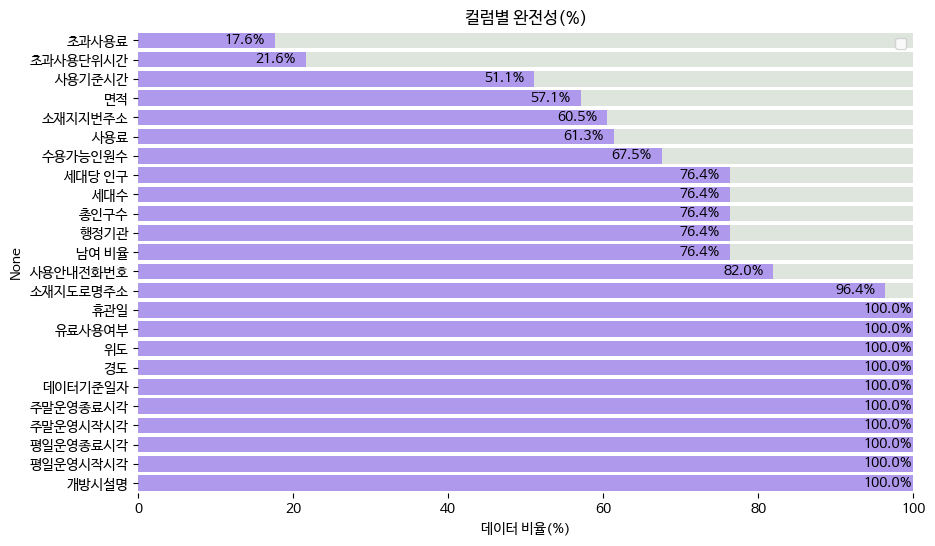

In [7]:
# plt 객체를 생성
plt.figure(figsize=(10, 6))

# 두 개의 데이터 열에 대해 스택바 차트로 시각화
sns.barplot(y=df_fill_rate.index, x='fill_rate(%)', data=df_fill_rate, color='#a78bfa')
sns.barplot(y=df_fill_rate.index, x='null_rate(%)', data=df_fill_rate, color='#DCE6DC', left=df_fill_rate['fill_rate(%)'])

# 레이블, 범례 등 설정
plt.xlabel('데이터 비율(%)')
plt.title('컬럼별 완전성(%)')
plt.legend()
plt.box(False)

# 채워진 데이터 비율 표시
for i in range(len(df_fill_rate)):
    plt.text(df_fill_rate['fill_rate(%)'][i]-6.5, i, f"{df_fill_rate['fill_rate(%)'][i]:.1f}%", fontsize=10, ha='left', va='center')

전체 데이터셋에 대한 완전성은 다음 식으로 계산할 수 있다.

$
complete_{data} = \frac{length(rows) * length(columns) - null_{data}}{length(rows) * length(columns)}
$



In [8]:
# 전체 데이터 개수 (행 x 열)
total_cells = df.shape[0] * df.shape[1]

# 공백 데이터 개수
null_cells = df.isnull().sum().sum()

# 채워진 데이터 비율
complete = (total_cells-null_cells) / total_cells * 100

# 소수점 둘째자리까지 반올림
complete = round(complete, 2)

print("완전성(%) : ", complete)

완전성(%) :  79.04


## 2. 이해가능성

이해가능성은 기계가 판독 가능한 기호, 문자로 구성되었는지에 대한 여부를 검사한다. 정규표현식을 활용해 기계가 판독하기 어렵거나 인코딩 오류가 날 소지가 있는 데이터를 검사한다. 이해가능성과 유효성, 정확성의 경우 구문 준수여부/값의 실존 여부를 0(미준수), 1(준수), None(공백\판단불가)로 표현한 후, 이를 집계하는 방식을 따른다. 이를 수식으로 표현하면 아래와 같다.

$
eval_i = \frac{length(row)-falsey_i-null_i}{length(row)-null_i}
$

여기서 $falsey_i$는 평가 테이블의 $i$ 테이블에서 0으로 표기된 값들을 의미한다.

### `check_readable`

`check_readable`함수는 개별 값에 대해 통상적으로 사용하지 않는 특수기호가 포함되었는지를 검사한다. 특수기호가 포함된 경우 0을, 정상적인 문자열이면 1을 리턴한다.

In [9]:
def check_readable(x):
    if x != None:
        # 정수형 및 부동소수점 형태는 통과
        if type(x) == float or type(x) == int:
            return 1
        # re.search 값이 None 이 아닌 경우 문제가 있는 문자열로 판단
        else:
            if re.search(r"[^[가-힣]\w\s,._-:;'0-9/+()]", x):
                return 0
            else:

                return 1
    else:
        # 공백값이나 판별이 불가능 경우는 'n'으로 리턴하고, 공백값으로 처리
        return "n"


In [10]:
# 컬럼별로 apply 함수를 적용해 개별 데이터의 구문적 오류를 탐
readable_list = []
for col in df.columns.tolist():
    correct = pd.DataFrame(df[col].apply(check_readable), columns =[col])
    readable_list.append(correct)

# readable 데이터프레임 업데이트를 위한 데이터프레임 생성
readable_df = pd.concat(readable_list, axis=1)

# readable 데이터프레임 업데이트
readable.update(readable_df[df.columns.tolist()])
readable = readable.replace('n', None)

### 결과종합

앞서 생성한 `vis_portion`함수를 통해 결과를 시각화한다.

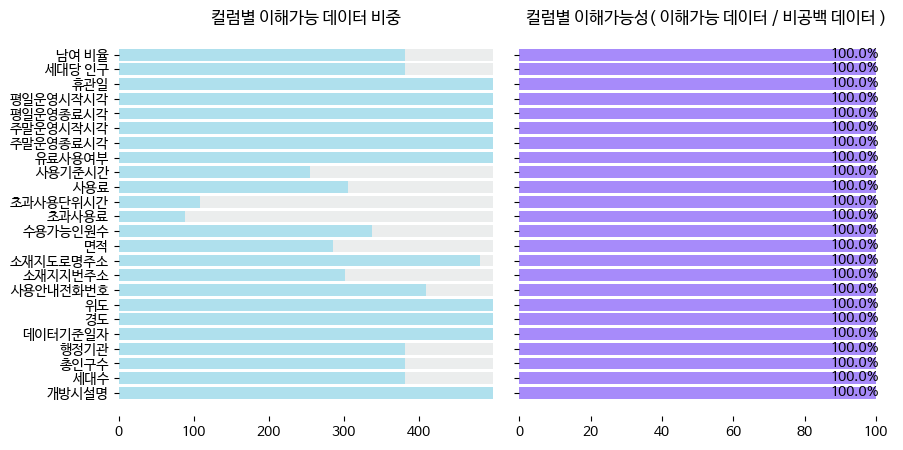

In [11]:
read_count = vis_portion(readable, "이해가능")

## 3.  유효성

유효성은 데이터 포맷별로 존재하는 구문 규칙에 따라 데이터의 유효성 여부를 판별해야 하므로, 컬럼별로 다양한 구문규칙을 적용해야 한다. 다음은 대표적으로 통용되는 구문적 규칙이 존재하는 컬럼들에 대한 정규표현식과 이를 적용하여 유효성을 평가하는 코드이다.

### 3.1. 시각컬럼 - `check_time_format`
- 시각 컬럼은 "HH:MM", 또는 "HH:MM:SS" 형식으로 표기되어야 한다.

In [12]:
# 시간 형식을 체크하는 함수
def check_time_format(input_str):
    # 시:분 형태의 시각 데이터를 체크
    pattern_1= r"^([0-9]|[0-1][0-9]|2[0-3]):([0-5][0-9])$"
    # 시:분:초 형태의 시각 데이터를 체크
    pattern_2 =r"^([0-9]|[0-1][0-9]|2[0-3]):([0-5][0-9]):([0-5][0-9])$"

    # 둘 중 한 패턴이라도 일치하는 부분이 있으면 1을, 둘 다 일치하지 않으면 0을 리턴
    if re.match(pattern_1, input_str) or re.match(pattern_2, input_str):
        return 1
    else:
        if input_str != None:
            return 0
        return None

In [13]:
time_col = ["평일운영시작시각","평일운영종료시각","주말운영시작시각","주말운영종료시각"]

# 판정이 끝난 컬럼값을 저장할 리스트
time_correct_list = []

# 컬럼별로 판정을 진행하여 리스트에 저장
for col in time_col:
    correct = pd.DataFrame(df[col].apply(check_time_format), columns =[col])
    time_correct_list.append(correct)

# valid 데이터프레임 업데이트를 위한 데이터프레임 생성
time_correct_df = pd.concat(time_correct_list, axis=1)

# valid 데이터프레임 업데이트
valid.update(time_correct_df[time_col])

### 3.2. 일자 컬럼 - `check_date_formate`

- 일자 컬럼은 "YYYY-MM-DD" 형식을 준수해야 한다.
- 추가적으로, 윤년이나 월별로 존재하는 일수도 확인한다.

In [14]:
# 일자 형식을 체크하는 함수
def check_date_format(input_str):

    # 기본적인 일자 형태에 대한 구문표현식
    pat=r"^\d{4}-\d{2}-\d{2}$"

    # 기본적인 일자 형태를 갖춘 경우, 구체적으로 일자가 유효한지 체크
    if re.match(pat, input_str):
        year = input_str.split("-")[0]
        month = input_str.split("-")[1]
        date = input_str.split("-")[2]

        # 윤년을 검증하는 부분
        # 윤년인데 2월 29일 이후의 일자가 있는 경우를 체크
        if ((int(year)%4 == 0 and int(year)%100 !=0) or (int(year)%4 == 0 and int(year)%100 ==0 and int(year)%400 == 0)) and int(month)==2 and int(date) >29:

            return 0

        else:
            #월별 일자 한도를 체크
            if int(month) in [1,3,5,7,8,10,12]:
                if int(date) > 31:
                    return 0
                else:
                    return 1
            else:
                if int(date) > 30:
                    return 0
                else:
                    return 1
    else:
        if input_str != None:
            return 0
        return None

date_correct_df = pd.DataFrame(df["데이터기준일자"].apply(check_date_format), columns =["데이터기준일자"])

# valid 데이터프레임 업데이트
valid.update(date_correct_df["데이터기준일자"])

### 3.3. 여부 컬럼 - `check_yn_format`
- 여부는 Y/N 의 값으로만 표기되어야 한다.

In [15]:
# 시간 형식을 체크하는 함수
def check_yn_format(input_str):

    # input 값이 Y인지 N인지를 판별
    if input_str == "Y" or input_str == "N":
        return 1
    else:
        if input_str != None:
            return 0
        return None

yn_correct_df = pd.DataFrame(df["유료사용여부"].apply(check_yn_format), columns =["유료사용여부"])

# valid 데이터프레임 업데이트
valid.update(yn_correct_df["유료사용여부"])

- 'n', '유료'는 명확히 Y,N값으로 변환할 수 있지만, '없음' 이나 "X"는 의미가 불명확하다. 따라서 n과 '유료'만 각각 "N","Y"로 변환하도록 하겠다.

In [16]:
df['유료사용여부'] = df['유료사용여부'].replace('n', "N").replace('유료', "Y").replace("없음", "N").replace("X", "N")
df["유료사용여부"].unique()

array(['Y', 'N'], dtype=object)

### 3.4. 전화번호 컬럼 - `check_phone_format`

- 전화번호는 보통 지역번호와 3~4자리의 숫자 그룹 2개가 "-"로 연결되어 있다.
- 전화번호의 유효성에 대한 구체적인 경우들이다.
    - 개인번호
        - NNN-NNNN-NNNN
        - NNN-NNN-NNNN
    - 지역번호를 포함한 번호
        - NN-NNN-NNNN
        - NN-NNNN-NNNN
        - NNN-NNN-NNNN
        - NNN-NNNN-NNNN
    - 대표번호
        - NNNN-NNNN
- 지역번호가 누락된 경우, 주소정보가 있다면 채워줄 수 있다.

In [17]:
# 전화번호 형식을 체크하는 함수
def check_phone_format(input_str):
    input_str = str(input_str)
    pat1  = r"^(0[1-9]{1,2}|[1-9]{1})-(?:[0-9]{3}|[0-9]{4})-[0-9]{4}$" # 지역번호 포함 전화번호 패턴
    pat2 =  r"^01[0-9]{1}-[0-9]{3,4}-[0-9]{4}$" # 휴대폰번호 패턴
    pat3 = r"^[0-9]{4}-[0-9]{4}$" # 대표번호 패턴
    if re.match(pat1, input_str) or re.match(pat2, input_str) or re.match(pat3, input_str):
        return 1
    else:
        if input_str != None:
            return 0
        else:
            return None

phone_correct_df = pd.DataFrame(df["사용안내전화번호"].apply(check_phone_format), columns =["사용안내전화번호"])

# valid 데이터프레임 업데이트
valid.update(phone_correct_df["사용안내전화번호"])

### 3.5. 좌표계 컬럼 - `check_coord_format`

- 좌표계는 소숫점 이하 숫자가 길어질수록 정확한 지점의 위치 표현이 가능하다.
- 공공데이터 표준데이터세트 가이드라인에서는 최소한 소수점 이하 6자리 이상의 값을 갖출 것을 명시하였다. 따라서, 본 문서에서도 이러한 기준을 받아들여 소수점 이하 6자리를 충족하지 못하는 데이터를 오류 데이터로 판별한다.
- 좌표계의 경우 위/경도 중 한 값이라도 누락된다면 유효한 데이터가 아니다. 따라서 좌표계의 유효성에 대해 검사할 때는 좌표쌍 요소의 누락도 함께 검사한다.
- 좌표쌍 요소의 누락은 `get_invalid_coord_rows`로 검사한다. 해당 함수는 누락된 쌍이 존재하는 행 번호를 리턴한다.

In [18]:
# 좌표계 자릿수 체크하는 함수
# '숫자.숫자'의 형태를 갖추는지 검사
def check_coord_format(input_str):
    pat =r"^-?\d+\.\d{6,}$"
    if re.match(pat, str(input_str)):
        return 1
    else:
        if input_str != None:
            return 0
        return None

# 위도, 경도 중 하나의 값이 빠지는 데이터 검사하는 함수
def get_invalid_coord_rows(df):
    notnull = df[['위도', '경도']].notnull().index
    invalid_coord_rows = []
    for i in notnull:
        if (df.loc[i, "위도"] is None and df.loc[i, "경도"] is not None) or \
            (df.loc[i, "경도"] is None and df.loc[i, "위도"] is not None):
                invalid_coord_rows.append(i)
    return invalid_coord_rows

# 자릿수 형식을 제대로 갖추고 있는지 검사
lat_correct_df = pd.DataFrame(df["위도"].apply(check_coord_format), columns =["위도"])
lon_correct_df = pd.DataFrame(df["경도"].apply(check_coord_format), columns =["경도"])


# 누락된 좌표쌍을 탐색
# 한 요소라도 누락되면 두 요소에 대한 유효성이 모두 0으로 부여
invalids = get_invalid_coord_rows(df)
lat_correct_df.iloc[invalids] = 0
lon_correct_df.iloc[invalids] = 0

# valid 테이블에 해당 컬럼의 값들을 업데이트
valid.update(lon_correct_df["경도"])
valid.update(lat_correct_df["위도"])


### 결과 종합

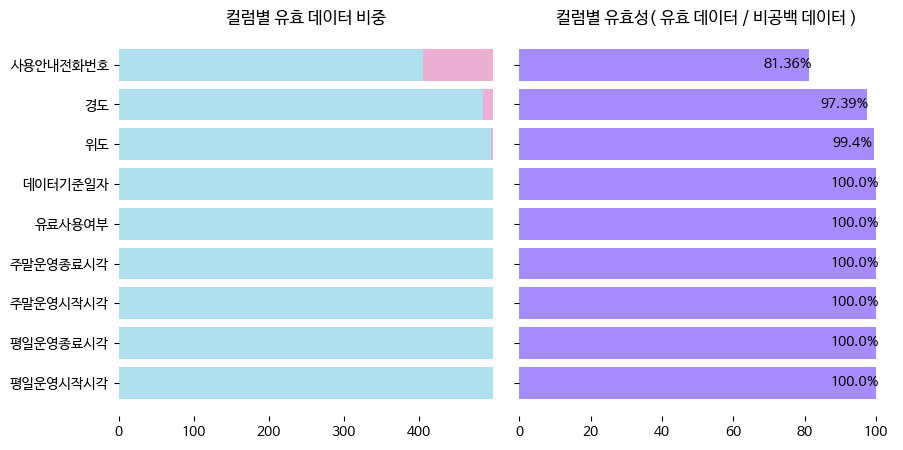

In [19]:
val_count = vis_portion(valid, "유효")

## 4. 정확성

**외부데이터 선정시 주의사항**
- 정확성 평가 시 참고하는 외부데이터는 최신성, 정확성을 확보하여야 하며, 평가 컬럼 내부에 존재하는 모든 값들이 존재하여야 한다.
- 본 문서에서는 정확성 평가 대상 컬럼으로 지번주소와 좌표계 컬럼을 선정하였다. 주소관련 데이터의 경우 네이버나 카카오, 구글 등에서 제공하는 데이터세트가 존재하므로, API 키만 갖고있다면 쉽게 정확성을 평가해볼 수 있다.

**좌표계-주소의 특성에 따른 일관성 평가 병행**
- 좌표계에 주소가 맵핑된다는 특성을 가지므로, 좌표계의 실존여부 평가 과정에는 리턴된 지번/도로명주소가 데이터 상에 존재하는 지번/도로명주소와 일치하는지에 대한 일관성도 함께 평가된다. 또한, 주소검색 API에서도 도로명/지번주소에 대한 검색 결과로 도로명주소와 지번주소 모두를 리턴하므로, 리턴된 주소값을 바탕으로 데이터 상의 주소와 리턴된 주소값을 비교해 일관성을 평가하도록 하겠다.

In [20]:
# 도로명주소, 지번주소 모두 존재하는 경우
addr_idx1 = df['소재지도로명주소'].notnull().index.tolist()
addr_idx2 = df['소재지지번주소'].notnull().index.tolist()

addr_idx = addr_idx1+addr_idx2
addr_idx = list(set(addr_idx))


### 4.1. 필요 함수 선언

#### `search_addr`
- 개별 주소값을 API에 검색하여 리턴 값을 받아오는 함수이다.

In [21]:
# 주소 검색 함수
def search_addr(addr):
    # 요청 헤더에는 API 키와 아이디 값을 입력
    headers = {"X-NCP-APIGW-API-KEY-ID":API_ID, "X-NCP-APIGW-API-KEY":API_SECRET}

    # 파라미터에는 검색할 주소를 입력
    params = {"query" : addr, "output":"json"}

    # 정보를 요청할 url
    url ="https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode"

    data = requests.get(url, headers=headers, params=params)

    return json.loads(data.text)

#### `search_coords`

- 좌표값을 API에 검색하여 리턴값을 받아오는 함수이다.

In [22]:
# 좌표 검색 함수
# 경도, 위도 순으로 입력
def search_coords(x,y):
    coord = f"{x},{y}"
    # 요청 헤더에는 API 키와 아이디 값을 입력
    headers = {"X-NCP-APIGW-API-KEY-ID":API_ID, "X-NCP-APIGW-API-KEY":API_SECRET}

    # 파라미터에는 변환할 좌표계를 입력 -> "경도,위도" 순으로 입력
    params = {"coords" : coord, "output":"json", "orders":"roadaddr,addr"}

    # 정보를 요청할 url
    url ="https://naveropenapi.apigw.ntruss.com/map-reversegeocode/v2/gc"

    data = requests.get(url, headers=headers, params=params)

    return json.loads(data.text)

#### `road_addr_maker`

- 리턴된 주소구성요소를 합성해 도로명주소를 생성하는 함수이다.

In [23]:
# 도로명주소를 합성하는 함수
def road_addr_maker(road_obj):
    road = road_obj["region"]["area1"]["name"] + " " + road_obj["region"]["area2"]["name"]
    if road_obj["region"]["area3"]["name"][-1] == "읍" or road_obj["region"]["area3"]["name"][-1] == "면":
        road += " " + road_obj["region"]["area3"]["name"]
    if road_obj["land"]["name"] != "":
        road += " " + road_obj["land"]["name"]
    if road_obj["land"]["number1"] != "":
        road += " " + road_obj["land"]["number1"]
    if  road_obj["land"]["number2"] != "":
        road += "-" + road_obj["land"]["number2"]
    return road

`addr_maker`
- 리턴된 주소구성요소를 합성해 지번주소를 생성하는 함수이다.

In [24]:
# 지번주소를 합성하는 함수
def addr_maker(addr_obj):
    addr = addr_obj["region"]["area1"]["name"] + " " + addr_obj["region"]["area2"]["name"] + " " + addr_obj["region"]["area3"]["name"]
    if addr_obj["region"]["area4"]["name"] != "":
        addr += " " + addr_obj["region"]["area4"]["name"]
    if addr_obj["land"]["type"] == "1":
        addr += " " + addr_obj["land"]["number1"]
    if addr_obj["land"]["type"] == "2":
        addr += " " + addr_obj["land"]["number1"]+"-"+addr_obj["land"]["number2"]
    return addr

`string_similarity`

- 도로명 주소의 경우, 상세주소나 참고항목들을 선택적으로 기입한다. 지번의 경우에도 건물명을 따로 표기하지 않은 경우가 많아, 데이터 상의 주소, API로 리턴받은 주소가 완벽하게 일치하지 않을 수 있다. 따라서, 데이터상의 주소가 API로 리턴된 주소와 일정 수준 이상으로 일치하면 동일한 데이터라고 판별하도록 처리한다.

In [26]:
def string_similarity(str1, str2):
    length1 = len(str1.split(" "))
    length2 = len(str2.split(" "))

    result = False
    if length1 == length2:
        matcher = difflib.SequenceMatcher(None, str1, str2)
        if matcher.ratio() >= 0.9:
            result = True
        else:
            result = False


    else:
        matcher = difflib.SequenceMatcher(None, str1, str2)
        if matcher.ratio() >= 0.6:
            result = True
        else:
            result = False
    return result

### 4.2. 도로명주소와 지번주소의 실존 & 일치 여부 확인

In [27]:
# 도로명주소, 지번주소가 존재하는 행만 추출
addr_idx1 = df['소재지도로명주소'].notnull().index.tolist()
addr_idx2 = df['소재지지번주소'].notnull().index.tolist()

addr_idx = addr_idx1+addr_idx2
addr_idx = list(set(addr_idx))


리턴값과 약간의 차이가 존재할 수 있으므로, 리턴값과 현재 값에 대한 일치율로 계산한다.

In [28]:
for i in tqdm(addr_idx):
    if (i in addr_idx1) and (i in addr_idx2):
        re_val = search_addr(df.loc[i, "소재지도로명주소"])

        # 검색한 주소가 존재하는지 확인
        if (re_val["status"] != "OK") or (re_val["meta"]["totalCount"] == 0):
            factual['소재지도로명주소'][i] = 0
        else:
            if re_val["status"] == "OK":
                factual['소재지도로명주소'][i] = 1

                # 소재지지번주소가 존재하는 경우
                if df['소재지지번주소'][i] != None:
                    sim = string_similarity(re_val["addresses"][0]["jibunAddress"], df["소재지지번주소"][i])
                    # 도로명주소와 지번주소가 일치하는 경우
                    if sim == True:
                        factual['소재지지번주소'][i] = 1
                        consist["소재지도로명주소-소재지지번주소"][i] = 1

                    # 도로명주소와 지번주소가 일치하지 않는 경우
                    else:
                        consist["소재지도로명주소-소재지지번주소"][i] = 0
                        jibun = search_addr(df.loc[i, "소재지지번주소"])
                        if jibun["status"] == "OK":
                            #소재지지번주소가 일치하진 않으나 존재하는 경우
                            factual['소재지지번주소'][i] = 1
                        else:
                            # 소재지지번주소가 아예 잘못된 주소인 경우
                            factual['소재지지번주소'][i] = 0

                # 소재지지번주소가 존재하지 않는 경우
                else:
                    factual['소재지지번주소'][i] = None
                    consist["소재지도로명주소-소재지지번주소"][i] = None



100%|██████████| 499/499 [09:22<00:00,  1.13s/it]


### 4.3. 좌표계의 실존 여부와 주소 데이터와의 일치 여부 확인

#### `without_details`

- API로 리턴되지 않을 수 있는 상세주소나 참고항목을 제거한다.

In [29]:
def without_details(i):
    if " (" in df['소재지도로명주소'][i]:
        eval_road = df['소재지도로명주소'][i].split(" (")[0]
    elif "(" in df['소재지도로명주소'][i]:
        eval_road = df['소재지도로명주소'][i].split("(")[0]
    else:
        eval_road = df['소재지도로명주소'][i].split(",")[0]
    return eval_road

In [30]:
# 검색이 가능한 유효한 좌표계만 추출한다.
# valid 테이블이 값을 활용한다.
val_coords = valid[(valid['위도'] == 1)&(valid['경도']==1)].index.tolist()

for i in tqdm(val_coords):
        # 좌표계 검색
        re_val = search_coords(df.loc[i, "경도"],df.loc[i, "위도"])

        # 검색한 좌표계가 존재하는지 확인
        if (re_val["status"]["name"] != "ok") or (len(re_val["results"]) == 0):
            factual['위도'][i] = 0
            factual['경도'][i] = 0
            consist["소재지지번주소-좌표계"][i] = None
            consist["소재지도로명주소-좌표계"][i] = None

        # 검색한 좌표계가 존재하는 경우
        else:
            factual['위도'][i] = 1
            factual['경도'][i] = 1

            # 지번, 도로명주소가 모두 존재하는 지점인 경우
            if len(re_val["results"]) == 2:
                road_obj = re_val["results"][0]
                addr_obj = re_val["results"][1]

                # 주소 합성
                road = road_addr_maker(road_obj)
                addr= addr_maker(addr_obj)

                # 각각의 주소가 존재하는 경우에 따라 비교
                # 도로명주소만 존재하는 경우
                if df['소재지도로명주소'][i] != None:
                    sim = string_similarity(road, df['소재지도로명주소'][i])
                    if sim == True:
                        consist["소재지도로명주소-좌표계"][i] = 1
                    else:
                        consist["소재지도로명주소-좌표계"][i] = 0
                else:
                    consist["소재지도로명주소-좌표계"][i] = None

                # 지번주소만 존재하는 경우
                if df['소재지지번주소'][i] != None:
                    sim = string_similarity(addr, df['소재지지번주소'][i])
                    if sim == True:
                        consist["소재지지번주소-좌표계"][i] = 1
                    else:
                        consist["소재지지번주소-좌표계"][i] = 0
                else:
                    consist["소재지지번주소-좌표계"][i] = None

            # 지번, 도로명 중 하나의 주소만 존재하는 경우
            # (일반적으로 지번만 존재하는 경우가 다수임)
            elif len(re_val["results"]) == 1:
                if re_val["results"][0]["name"] == "roadaddr":
                    road_obj = re_val["results"][0]
                    road = road_addr_maker(road_obj)
                    if df['소재지도로명주소'][i] != None:
                        sim = string_similarity(road, df['소재지도로명주소'][i])
                        if sim == True:
                            consist["소재지도로명주소-좌표계"][i] = 1
                        else:
                            consist["소재지도로명주소-좌표계"][i] = 0
                    else:
                        consist["소재지도로명주소-좌표계"][i] = None
                else:
                    addr_obj = re_val["results"][0]
                    addr= addr_maker(addr_obj)
                    if df['소재지지번주소'][i] != None:
                        sim = string_similarity(addr, df['소재지지번주소'][i])
                        if sim == True:
                            consist["소재지지번주소-좌표계"][i] = 1
                        else:
                            consist["소재지지번주소-좌표계"][i] = 0
                    else:
                        consist["소재지지번주소-좌표계"][i] = None


100%|██████████| 483/483 [08:37<00:00,  1.07s/it]


### 결과 종합

,1.0,0.0,none,정확
위도,483,16,0,96.793587
경도,483,16,0,96.793587
소재지도로명주소,481,18,0,96.392786
소재지지번주소,284,18,197,94.039735


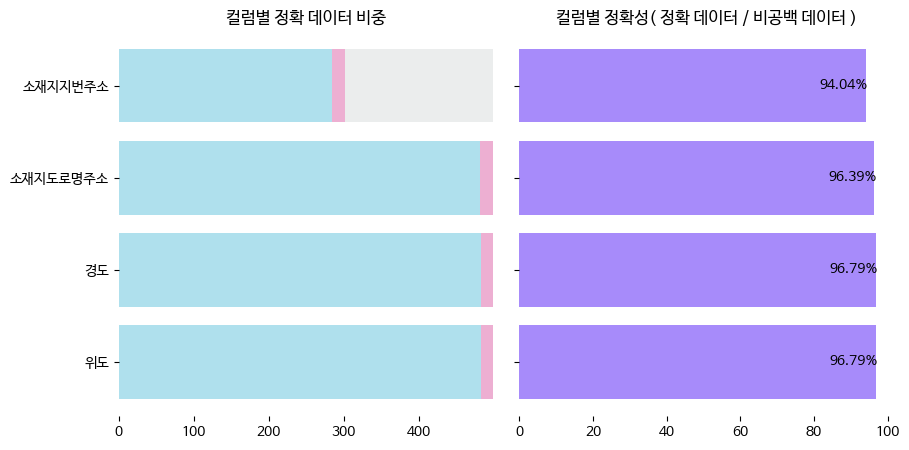

In [31]:
fact_count = vis_portion(factual, "정확")
fact_count

## 5. 일관성
- 일관성은 두 컬럼이 의미적으로 관계가 있는 경우, 이 둘의 값들이 논리적인지를 평가한다.
- 예를들어 복수의 컬럼 값에 대한 총합 컬럼이 있는 경우, 해당 컬럼의 값들은 모두 두 컬럼의 값의 합으로만 구성되어야 한다.
- 어떤 컬럼의 T/F, 또는 값의 존재 여부에 따라 다른 컬럼의 값이 영향을 받는 경우, 개별 값에 따라 가질 수 있는 값인지를 평가할 수도 있다.
- 일관성은 두 컬럼세트 값을 비교하여, 해당 행에 존재하는 두 데이터 쌍이 논리적으로 타당한 경우 1, 아닌 경우는 0, 둘 중 한 값이 공백인 경우(어떠한 값에 대해 존재하는 공백값이 아닌, 마땅히 존재해야하는 값이 공백인 경우) None을 부여한다.

### 5.1. 휴관일과 주말운영시작/종료시각
- 편리한 비교를 위해 "-요일", "-일" 을 제거해주도록 한다.

In [32]:
def day_cleaner(x):
    if "요일" in x:
        x = x.replace("요일", "")
    if "공휴일" in x:
        x = x.replace("공휴일", "공휴")
    return x

df['휴관일'] = df['휴관일'].apply(lambda x: day_cleaner(x))
df['휴관일'].unique()

array(['공휴+일', '연중무휴', '매월 2째주, 4째주 일', '토+일+공휴', '토+공휴', '공휴', '토+일',
       '토(12월~2월)+일', '설날 연휴+추석 연휴', '일+법정 공휴', '설연휴+추석연휴', '법정공휴', '월',
       '월+일', '연중무휴(월~금 학교 사용으로 인해 주말만 사용가능)', '첫째 주 일+셋째 주 일',
       '둘째 주 일+넷째 주 일', '일', '수+토+일+공휴', '금', '월+화+수+금+일', '설 연휴+추석 연휴',
       '일+공휴+설 연휴+추석 연휴', '일+공휴', '주말+공휴', '월+1월1일+설 연휴+추석 연휴',
       '월+설 당일+추석 당일', '매주 월, 1월 1일, 설·추석 당일', '금+토+일', '월+법정 공휴', '일+월',
       '잔디휴면기(8월)+동절기(12월~2월)', '잔디휴면기(8월)+동절기(12월~3월)', '화+동절기(12월~3월)',
       '화+동절기(11월~3월)', '월+공휴', '토+일+법정휴일', '설,추석 당일', '매주 화/법정공휴',
       '매주화/법정공휴', '1,3주 일 및 법정공휴', '월+동절기(1~3월)', '토+일+ 공휴',
       '둘째 주 금+넷째 주 금', '월+일 제외한 공휴', '토+일+법정공휴', '매주 일',
       '추석연휴+설연휴+근로자의날', '토+일+추석연휴+설연휴+근로자의날+공휴', '토+일+추석연휴+설날연휴+근로자의날',
       '매주 일+매주 월+법정공휴', '1월 1일+설날+추석+매주 월(다만, 월이 공휴인 경우 그 다음날)',
       '월+설연휴+추석연휴', '일+1월 1일+설 연휴+추석 연휴', '1월 1일+설 연휴+추석 연휴', '1, 3주 일'],
      dtype=object)

In [33]:
# 맵핑 테이블
def  map_table(x,y):
    if x != None:
        if "토+일" in x: # 토요일/일요일이 휴관일
            if y == None:
                return 1
            else: # 주말이 휴관일인데 주말운영시각이 존재하는 경우
                return 0
        else:
            return 1
    else:
        return 1

# apply를 활용한 맵핑 테이블 적용
consist["휴관일-주말운영시작시각"] = df.apply(lambda x: map_table(x['휴관일'], x['주말운영시작시각']), axis=1)
consist["휴관일-주말운영종료시각"] = df.apply(lambda x: map_table(x['휴관일'], x['주말운영종료시각']), axis=1)

### 5.2. 유료사용여부와 사용료

In [34]:
df['사용료'] = df['사용료'].replace("0","무료")

In [35]:
def  yn_map_table(x,y):
    if x == "Y":
        if y == None:
            return None
        elif y == "무료":
            return 0
        else:
            return 1
    else:
        if x == "N":
            if y == "무료":
                return 1
            elif y == None:
                return None
            else:
                return 0
        else:
            return None


In [36]:
consist["유료사용여부-사용료"] = df.apply(lambda x: yn_map_table(x['유료사용여부'], x['사용료']), axis=1)

### 결과 종합

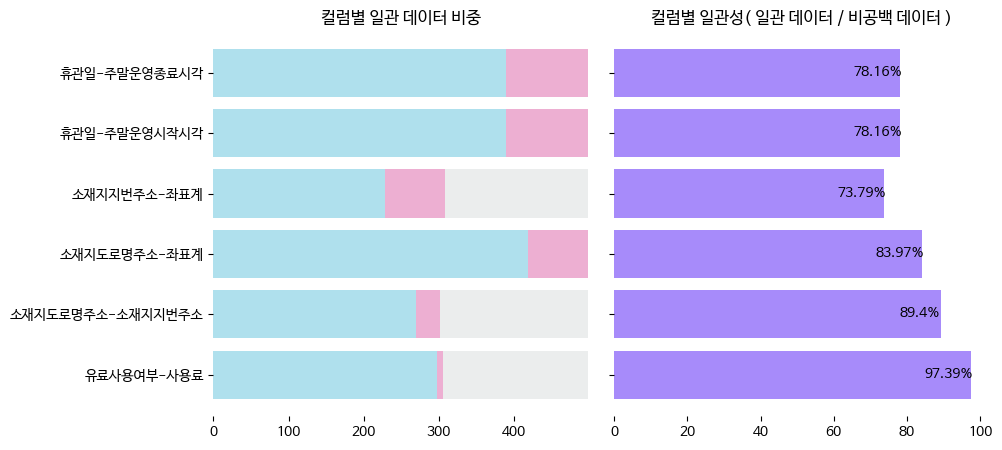

In [37]:
cons_count = vis_portion(consist, "일관")

In [38]:
consist.to_excel("consist.xlsx", index=False)

In [39]:
dfff = consist.copy()
dfff['도로명'] = df['소재지도로명주소']
dfff['지번'] =df['소재지지번주소']

dfff.to_excel("7-6_consistcheck.xlsx", index=False)

## 전체 결과 종합

앞서 구한 컬럼별 완전성, 이해가능성, 유효성, 정확성, 일관성의 전체 평균을 구한다. 완전성과 이해가능성을 제외한 나머지 평가항목들의 경우 모든 컬럼에 대해 평가 한 것은 아니므로 평균에 대한 수치가 곧 전체 데이터의 품질을 의미하는 것이라고 정의할 수는 없으나, 실용적인 관점에서 대략적인 데이터의 품질 수준을 파악할 수 있다.

In [41]:
import plotly.express as px
fact_total = fact_count['정확'].mean()
cons_total = cons_count['일관'].mean()
read_total = read_count['이해가능'].mean()
val_total = val_count['유효'].mean()
comp_total = complete

total_eval = pd.DataFrame(columns=["element", "rate"])
total_eval["element"] = ["완전성","이해가능성", "유효성", "정확성", "일관성"]
total_eval['rate'] = [comp_total, read_total, val_total, fact_total, cons_total]

fig = px.line_polar(r=total_eval["rate"], theta=total_eval["element"],line_close=True)

fig.update_traces(fill='toself')
fig.show()